In [1]:
import os
import sys
path = os.path.dirname(os.getcwd())
new_path = os.path.join(path, 'src')
sys.path.insert(0,new_path)

import pandas as pd
import numpy as np                     
import math
import matplotlib.pyplot as plt             #visualisation
import sklearn

from sklearn.utils import shuffle
from sklearn import utils
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn import preprocessing, svm
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error
import random

from constants import Tube 
import models.modeling_pipeline as mp
import models.train_model as tm
from features.build_features import add_flaw_info_to_df 

random.seed(10)


##### import the data

In [3]:
data_path = os.path.join(os.path.dirname(os.getcwd()),'data', 'interim', 'full_feature_data.csv')
df = pd.read_csv(data_path)

change_list = mp.find_features(df, ['AB'])

no_hole_df = df[df.Flaw_Depth < 0.71]
no_hole_df = no_hole_df.reset_index()

### Choose models: 
 1) Classification of through holes
 
 2) Models for Depth and Volume 
 
 3) Models for iterative refinement that depend on the area/depth found in previous iterations

In [4]:
#to be used for automisation
classifier_model= RandomForestClassifier()
depth_model=LinearRegression()
volume_model=LinearRegression()
#for iterations
depth_a_model=LinearRegression()
area_model = LinearRegression()

### Prepare the datasets

In [6]:
# Generate group labels by tube/defect pair
groups_labels = tm.generate_groups(df)
groups_labels_nh = tm.generate_groups(no_hole_df)
sc = StandardScaler()

# Generate list of features to be trained
feature_list = mp.find_features(df, ['Amp','Phase','AB','A_','B_'])
feature_list_area = mp.find_features(df, ['Amp','Phase','AB','A_','B_','Flaw_Area'])
feature_list_depth = mp.find_features(df, ['Amp','Phase','AB','A_','B_','Flaw_Depth'])

#add column for the classifier 
df['Through_Hole'] = 0.0
df.loc[(df['Flaw_Depth']>0.7),'Through_Hole'] =1


#split dataset for test and training
X_train, X_test, y_train, y_test, train_df, test_df = mp.get_scaled_training_test_data(df ,
                                    y_var=['Flaw_Depth','Flaw_Volume','Flaw_Area','Through_Hole'], method='four')


X_no_hole, y_no_hole= mp.get_one_data_set(no_hole_df, ['Flaw_Depth', 'Flaw_Area','Flaw_Volume'] )



## Model parameter optimisation:

In [7]:
#optimize the classifier
def rf_randomsearch_params(df, feature_list, y_feature, n_runs, no_folds):
    '''
    Use RandomSearchCV to go through a list of parameter combinations for RandomForest and return 
    a model trained on the best determined parameters along with the list of best parameters
    feature_list is a list of features
    y_feature is a string
    n_runs is an integer which determines how many iterations RandomSearch goes through before arriving at an answer
    no_folds is the number of k-folds for cv
    '''
    
    # A grid of parameters to search through
    n_estimators = [int(x) for x in np.linspace(start = 5, stop = 50, num = 5)]
    min_samples_leaf = [2,5,10]
    max_depth = [1,3,5,10,15]
    bootstrap = [True, False]
    min_samples_split = [2,5,10]
    min_samples_leaf = [1,2,4]
    max_features = ['auto', 'sqrt']
    random_grid = {
                   'n_estimators': n_estimators,
                   'min_samples_leaf': min_samples_leaf,
                    'max_depth' : max_depth,
        'bootstrap':bootstrap,
        'min_samples_split':min_samples_split,
        'max_features':max_features
                        }
    

    rf = RandomForestClassifier()
    # Generate object for group k-folding
    gkf = tm.generate_groupcv_object(df[feature_list], df[y_feature], groups_labels, no_folds )
    
    # Search best cv score across different combinations using random search and use all available cores.
    rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = n_runs, cv = gkf, random_state=42, n_jobs = -1)
    rf_random.fit(df[feature_list], df[y_feature])

    gkf = tm.generate_groupcv_object(df[feature_list], df[y_feature], groups_labels, no_folds )
    
    # Get best parameters
    rf_params = rf_random.best_params_
    rf = RandomForestClassifier()
    rf.set_params(**rf_params)
    scores = cross_val_score(rf, df[feature_list], df[y_feature], cv = gkf, scoring='accuracy')
    
    rf = RandomForestClassifier()
    rf.set_params(**rf_params) 
    rf.fit(df[feature_list], df[y_feature])
    # Best parameter accuracy on training set
    train_accuracy = 1-abs(rf.predict(df[feature_list])- df[y_feature]).mean()
    print('Training accuracy:' + str(train_accuracy*100))
    # Best parameter accuracy on cv set
    print('CV accuracy:' + str(scores.mean()))
    
    return rf, rf_params

In [8]:
[rf, rf_params] = rf_randomsearch_params(df, feature_list, 'Through_Hole', 20, 5)
print('Random Search parameters:', rf_params)

Training accuracy:100.0
CV accuracy:0.9838303036218135
Random Search parameters: {'n_estimators': 27, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'auto', 'max_depth': 15, 'bootstrap': False}


In [8]:
#find relevant features for linear regression models
no_folds = 5
y_feat_depth = 'Flaw_Depth'
y_feat_vol = 'Flaw_Volume'
y_feat_area = 'Flaw_Area'

# Train lasso and elastic nets to get features for depth models
[model_lasso, model_elasticnets, coef_lasso, coef_elasticnets] = tm.lasso_elasticnets_groupcv(no_hole_df, 
                                                    feature_list, y_feat_depth, groups_labels_nh, no_folds)

#Get coefficients of lasso that are non-zero and greater than 0.000
depth_list = (coef_lasso.index[abs(coef_lasso['Coefficients']) >0.000].tolist())

#Remove interept coefficient
depth_list = depth_list[:-1]

# Generate object for doing group k-folding for cross-validation
gkf = tm.generate_groupcv_object(no_hole_df[depth_list], no_hole_df[y_feat_depth], groups_labels_nh, no_folds)

# Perform cross-validation on linear model
ols2 = depth_model
ols_cv_mse = cross_val_score(ols2, no_hole_df[depth_list], no_hole_df[y_feat_depth], scoring='neg_mean_squared_error', cv=gkf)

# Average the MSE for different k-folds and convert into RMSE
ols_cv_rmse = np.sqrt(abs(ols_cv_mse).mean())
print(ols_cv_rmse)

##################################################################################
# Train lasso and elastic nets to get features for volume models
[model_lasso_v, model_elasticnets_v, coef_lasso_v, coef_elasticnets_v] = tm.lasso_elasticnets_groupcv(no_hole_df, 
                                                    feature_list, y_feat_vol, groups_labels_nh, no_folds)

#Get coefficients of lasso that are non-zero and greater than 0.000
volume_list = (coef_lasso_v.index[abs(coef_lasso_v['Coefficients']) >0.000].tolist())

#Remove interept coefficient
volume_list = volume_list[:-1]

# Generate object for doing group k-folding for cross-validation
gkf_v = tm.generate_groupcv_object(no_hole_df[volume_list], no_hole_df[y_feat_vol], groups_labels_nh, no_folds)

# Perform cross-validation on linear model
ols_v = volume_model
ols_v_cv_mse = cross_val_score(ols_v, no_hole_df[volume_list], no_hole_df[y_feat_vol], scoring='neg_mean_squared_error', cv=gkf_v)

# Average the MSE for different k-folds and convert into RMSE
ols_v_cv_rmse = np.sqrt(abs(ols_v_cv_mse).mean())
print(ols_v_cv_rmse)


#######################################################################################
# Train lasso and elastic nets to get features for depth with area-feature models
[model_lasso_a, model_elasticnets_a, coef_lasso_a, coef_elasticnets_a] = tm.lasso_elasticnets_groupcv(no_hole_df, 
                                                    feature_list_area, y_feat_depth, groups_labels_nh, no_folds)

#Get coefficients of lasso that are non-zero and greater than 0.000
depth_a_list = (coef_lasso_a.index[abs(coef_lasso_a['Coefficients']) >0.000].tolist())

#Remove interept coefficient
depth_a_list = depth_a_list[:-1]

# Generate object for doing group k-folding for cross-validation
gkf_a = tm.generate_groupcv_object(no_hole_df[depth_list], no_hole_df[y_feat_depth], groups_labels_nh, no_folds)

# Perform cross-validation on linear model
ols_a = depth_a_model
ols_a_cv_mse = cross_val_score(ols_a, no_hole_df[depth_a_list], no_hole_df[y_feat_depth], scoring='neg_mean_squared_error', cv=gkf_a)

# Average the MSE for different k-folds and convert into RMSE
ols_a_cv_rmse = np.sqrt(abs(ols_a_cv_mse).mean())
print(ols_a_cv_rmse)

#######################################################################################
# Try a depth dependent area prediction
# Train lasso and elastic nets to get features for depth with area-feature models
[model_lasso_area, model_elasticnets_area, coef_lasso_area, coef_elasticnets_area] = tm.lasso_elasticnets_groupcv(no_hole_df, 
                                                    feature_list_depth, y_feat_area, groups_labels_nh, no_folds)

#Get coefficients of lasso that are non-zero and greater than 0.000
area_list = (coef_lasso_area.index[abs(coef_lasso_area['Coefficients']) >0.000].tolist())

#Remove interept coefficient
area_list = area_list[:-1]

# Generate object for doing group k-folding for cross-validation
gkf_area = tm.generate_groupcv_object(no_hole_df[area_list], no_hole_df[y_feat_area], groups_labels_nh, no_folds)

# Perform cross-validation on linear model
ols_area = area_model
ols_area_cv_mse = cross_val_score(ols_area, no_hole_df[area_list], no_hole_df[y_feat_area], scoring='neg_mean_squared_error', cv=gkf_area)

# Average the MSE for different k-folds and convert into RMSE
ols_area_cv_rmse = np.sqrt(abs(ols_area_cv_mse).mean())
print(ols_area_cv_rmse)

Lasso optimization results : Compression = 37.43% , alpha : 4.9270937047431484e-06, CV RMSE : 0.04586
Elastic Nets optimization results : Compression = 16.71% alpha : 1.1933160405009603e-06, CV RMSE 0.04582
0.04519627006251644


C:\Users\Ted\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14.568311404427732, tolerance: 4.780343411948798
  positive)


Lasso optimization results : Compression = 15.25% , alpha : 1.1641512380646198e-05, CV RMSE : 0.76823
Elastic Nets optimization results : Compression = 47.06% alpha : 2.32830247612924e-05, CV RMSE 0.9176
0.7662385462607123
Lasso optimization results : Compression = 27.83% , alpha : 3.3097635552250817e-06, CV RMSE : 0.0434
Elastic Nets optimization results : Compression = 16.37% alpha : 1.1933160405009603e-06, CV RMSE 0.0436
0.04331134049957287


C:\Users\Ted\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 63.42839305659436, tolerance: 23.249642588526925
  tol, rng, random, positive)
C:\Users\Ted\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 70.03657917902456, tolerance: 23.249642588526925
  tol, rng, random, positive)
C:\Users\Ted\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 49.98673607810633, tolerance: 23.249642588526925
  tol, rng, random, positive)
C:\Users\Ted\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might wan

C:\Users\Ted\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 63.38196570970467, tolerance: 23.61200504159547
  tol, rng, random, positive)
C:\Users\Ted\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 103.7365142556373, tolerance: 23.61200504159547
  tol, rng, random, positive)
C:\Users\Ted\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 64.08053836709587, tolerance: 23.61200504159547
  tol, rng, random, positive)
C:\Users\Ted\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want t

C:\Users\Ted\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 94.01661243369017, tolerance: 23.61200504159547
  tol, rng, random, positive)
C:\Users\Ted\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 86.95390256270184, tolerance: 23.61200504159547
  tol, rng, random, positive)
C:\Users\Ted\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 87.08217705327843, tolerance: 23.61200504159547
  tol, rng, random, positive)
C:\Users\Ted\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want t

C:\Users\Ted\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 40.80143239670724, tolerance: 21.785162375373314
  tol, rng, random, positive)
C:\Users\Ted\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 46.67510403838969, tolerance: 21.785162375373314
  tol, rng, random, positive)
C:\Users\Ted\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 63.32777712294774, tolerance: 21.785162375373314
  tol, rng, random, positive)
C:\Users\Ted\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might wan

C:\Users\Ted\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 77.55749188068148, tolerance: 21.785162375373314
  tol, rng, random, positive)
C:\Users\Ted\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 58.40240781640023, tolerance: 21.785162375373314
  tol, rng, random, positive)
C:\Users\Ted\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 71.56411723936617, tolerance: 21.785162375373314
  tol, rng, random, positive)
C:\Users\Ted\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might wan

C:\Users\Ted\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 42.290925176785095, tolerance: 19.818854839016453
  tol, rng, random, positive)
C:\Users\Ted\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 57.45273668158916, tolerance: 19.818854839016453
  tol, rng, random, positive)
C:\Users\Ted\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 43.693095953152806, tolerance: 19.818854839016453
  tol, rng, random, positive)
C:\Users\Ted\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might w

C:\Users\Ted\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 45.72686078787956, tolerance: 23.36332621420098
  tol, rng, random, positive)
C:\Users\Ted\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 48.20562627802428, tolerance: 23.36332621420098
  tol, rng, random, positive)
C:\Users\Ted\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 51.151487638686376, tolerance: 23.36332621420098
  tol, rng, random, positive)
C:\Users\Ted\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want 

C:\Users\Ted\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 62.698351254126464, tolerance: 23.36332621420098
  tol, rng, random, positive)
C:\Users\Ted\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 49.82413325657399, tolerance: 23.36332621420098
  tol, rng, random, positive)
C:\Users\Ted\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 59.0184407056222, tolerance: 23.36332621420098
  tol, rng, random, positive)
C:\Users\Ted\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want t

C:\Users\Ted\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 70.14221068991901, tolerance: 23.36332621420098
  tol, rng, random, positive)
C:\Users\Ted\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 76.99201493011788, tolerance: 23.36332621420098
  tol, rng, random, positive)
C:\Users\Ted\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 68.81825588207721, tolerance: 23.36332621420098
  tol, rng, random, positive)
C:\Users\Ted\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want t

C:\Users\Ted\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 64.90060295600415, tolerance: 23.36332621420098
  tol, rng, random, positive)
C:\Users\Ted\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 63.231628495515906, tolerance: 23.36332621420098
  tol, rng, random, positive)
C:\Users\Ted\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 60.01440237899806, tolerance: 23.36332621420098
  tol, rng, random, positive)
C:\Users\Ted\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want 

Lasso optimization results : Compression = 21.87% , alpha : 2.716376638743443e-05, CV RMSE : 3.67058
Elastic Nets optimization results : Compression = 64.79% alpha : 4.292934212221147e-05, CV RMSE 4.11783
4.017716346216736


In [9]:
ols2.fit(no_hole_df[depth_list], y_no_hole['Flaw_Depth'])
ols_v.fit(no_hole_df[volume_list], y_no_hole['Flaw_Volume'])
ols_a.fit(no_hole_df[depth_a_list], y_no_hole['Flaw_Depth'])
ols_area.fit(no_hole_df[area_list], y_no_hole['Flaw_Area'])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

### Iteratively update deptha and area predictions until they converge

In [10]:
def update_values(df, area_predictions,volume_predictions, feature_list, reg_a_model):
    if 'Flaw_Area' in df.columns:
        new_area_df=df.drop(columns='Flaw_Area')
    else:
        new_area_df=df
    new_area_df['Flaw_Area'] =area_predictions
    
    new_depth_pred = reg_a_model.predict(new_area_df[feature_list]) 
    for i, a in enumerate(new_depth_pred): 
        if a<0:
            new_depth_pred[i] = 0.07
            
    new_area_predictions = volume_predictions/new_depth_pred
    #print(new_area_pred)
    delta_area= new_area_predictions-new_area_df['Flaw_Area']
  
    return new_depth_pred, new_area_predictions, delta_area


def update_area_model_values(df, area_predictions, feature_list, area_list, reg_a_model, reg_area_model):
    if 'Flaw_Area' in df.columns:
        new_area_df=df.drop(columns='Flaw_Area')
    else:
        new_area_df=df
    new_area_df['Flaw_Area'] =area_predictions
    #print(new_area_df['Flaw_Area'])
    new_depth_pred = reg_a_model.predict(new_area_df[feature_list]) 
    for i, a in enumerate(new_depth_pred): 
        if a<0:
            new_depth_pred[i] = 0.07
    
    if 'Flaw_Depth' in df.columns:
        new_depth_df=df.drop(columns='Flaw_Depth')
    else:
        new_depth_df=df 
    new_depth_df['Flaw_Depth'] =new_depth_pred
    new_area_pred = reg_area_model.predict(new_depth_df[area_list])
    for i, a in enumerate(new_area_pred): 
        if a<0.4:
            new_area_pred[i] = 0.4

    #print(new_area_pred)
    delta_area= new_area_pred-new_area_df['Flaw_Area']
    delta_ave=delta_area.mean() 
  
    return new_depth_pred, new_area_pred, delta_area, delta_ave

#update area and depth predictions until they converge to within delta_threshold or the maximum number of 
#iterations is reached (or the change changes sign)

def iterate_predictions(reg_a_model, df, depth_pred, volume_pred, area_pred, feature_list, th_ndx, alpha=0.2, 
                         delta_threshold = 0.02, max_loops=20, tube_thickness=0.737): 

    loop=0
    delta_list=[]
    delta_abs=20
    delta_ave=20
    delta_area=[]
    delta_ave_prev = delta_ave

    while  (loop < max_loops) & (delta_abs > delta_threshold) & (delta_ave*delta_ave_prev > 0)  :
            # & (delta_ave*delta_ave_prev > 0)):
        delta_ave_prev = delta_ave
        delta_area_prev = delta_area
        new_depth_pred, new_area_pred, delta_area = update_values(df,
                                                        area_pred, volume_pred, feature_list, reg_a_model)   
        if loop==0:
            delta_ave_prev = delta_ave 
            delta_area_prev = delta_area
        
        
        #only refine the mid range 
        for i, d in enumerate(depth_pred): 
            if d < tube_thickness/5.0:
                new_area_pred[i] = area_pred[i]
                new_depth_pred[i]=depth_pred[i]
                delta_area[i] = 0
   
        for i in th_ndx: 
            delta_area[i] = 0

        #update the area prediction array with a fraction alpha of the calculated differece to avoid 
        # overshooting
        area_pred=area_pred + alpha*delta_area
        
        delta_ave=delta_area.mean()
        delta_abs=abs(delta_area.mean())
        delta_list.append(delta_ave)
        
        loop+=1
    print(loop, 'iterations')    
    return  delta_list, new_depth_pred, new_area_pred
  

def iterate_predictions_area_model(reg_a_model, reg_area_model, df, area_pred, depth_list,area_list, alpha=0.2, 
                         delta_threshold = 0.02, max_loops=20): 

    loop=0
    rmse_list=[]
    delta_list=[]
    delta_abs=20
    delta_ave=20
    delta_ave_prev = delta_ave

    while  (loop<max_loops) & (delta_abs > delta_threshold) & (delta_ave*delta_ave_prev > 0)  :
            # & (delta_ave*delta_ave_prev > 0)):
        delta_ave_prev = delta_ave
        new_depth_pred, new_area_pred, delta_area, delta_ave=update_area_model_values(df,
                                                          area_pred, depth_list, area_list, reg_a_model, reg_area_model )
          
        if loop==0:delta_ave_prev =delta_ave 
        delta_abs=abs(delta_area.mean())

        #update the area prediction array with a fraction alpha of the calculated differece to avoid 
        # overshooting
        area_pred=area_pred+alpha*delta_area
        delta_list.append(delta_ave)
        
        loop+=1
        
    return delta_list, new_depth_pred, new_area_pred    

In [11]:
def predict_iterative_model(df, clas_model, depth_model, volume_model, depth_area_model, feature_clas,
                             feature_depth, feature_volume, feature_depth_area, tube_thickness=0.737,alpha=0.05, 
                                                     delta_threshold = 0.02, max_loops=20 ):
    #find the through holes
    thru_hole = clas_model.predict(df[feature_clas])
    indx_thru_hole = [i for i, x in enumerate(thru_hole) if x ==1]
    
    #predict the first round of values:
    #area
    depth_pred = depth_model.predict(df[feature_depth])
    
    #correct negative predictions
    for i, a in enumerate(depth_pred): 
        if a<0.1:
            depth_pred[i] = 0.1
    
    #volume
    volume_pred = volume_model.predict(df[feature_volume]) 
            
    for i, v in enumerate(volume_pred): 
        if v<0.08:
            volume_pred[i] = 0.08
    
    #calculate area
    area_pred = volume_pred/depth_pred
    #cap the area predictions for shallow holes
    for i, a in enumerate(area_pred): 
        if depth_pred[i]<tube_thickness/5.0:
            if a> 3*volume_pred[i]:
                area_pred[i] = 3*volume_pred[i]
    
    delta_areas, final_depth_pred, final_area_pred = iterate_predictions(depth_area_model, df, 
                                                    depth_pred, volume_pred, area_pred, feature_depth_area, 
                                                    indx_thru_hole, alpha, delta_threshold , max_loops)
    
    for i in indx_thru_hole:
        final_depth_pred[i] = tube_thickness
        volume_pred[i]/= 3.2
        final_area_pred[i] = volume_pred[i]/tube_thickness
   
    return final_depth_pred, final_area_pred, volume_pred, delta_areas



#** predict a depth dependent area directly rather than the volume************************************
# This appears to do worse on the depths but slightly better for the areas
def predict_iterative_area_model(df, clas_model, depth_model,area_model, depth_area_model, feature_clas,
                             feature_depth, feature_area, feature_depth_area, tube_thickness=0.737, alpha=0.1, 
                                                     delta_threshold = 0.02, max_loops=20):
    #find the through holes
    thru_hole = clas_model.predict(df[feature_clas])
    indx_thru_hole = [i for i, x in enumerate(thru_hole) if x ==1]
    
    #predict the first round of values:
    #area
    depth_pred = depth_model.predict(df[feature_depth])
    
    #correct negative predictions
    for i, a in enumerate(depth_pred): 
        if a<0:
            depth_pred[i] = 0.07
    
    #area
    #set the flaw depth to predictions
    if 'Flaw_Depth' in df.columns:
        new_depth_df=df.drop(columns='Flaw_Depth')
    else:
        new_depth_df=df
    new_depth_df['Flaw_Depth'] =depth_pred
    area_pred = area_model.predict(new_depth_df[feature_area])
    for i, a in enumerate(area_pred): 
        if a<0.4:
            area_pred[i] = 0.4

    
    delta_areas, final_depth_pred, final_area_pred = iterate_predictions_area_model(depth_area_model, area_model,
                                             df, area_pred, feature_depth_area,feature_area, alpha, 
                                                     delta_threshold, max_loops)
    
    for i in indx_thru_hole:
        final_depth_pred[i] = tube_thickness
        final_area_pred[i]/=3.2
   
    return final_depth_pred, final_area_pred, delta_areas



In [12]:
depth_pred, area_pred, volume_pred, delta_areas = predict_iterative_model(df, rf, ols2,
                                                        ols_v, ols_a, feature_list,
                             depth_list, volume_list, depth_a_list, tube_thickness=0.737, alpha=0.1, 
                                                     delta_threshold = 0.02, max_loops=10)
rmse_d = math.sqrt(mean_squared_error(df['Flaw_Depth'], depth_pred))
rmse_v = math.sqrt(mean_squared_error(df['Flaw_Volume'], volume_pred))
rmse_a= math.sqrt(mean_squared_error(df['Flaw_Area'], area_pred))
print('RMSE for depth: ',rmse_d, ', volume:', rmse_v, ', area:', rmse_a)

8 iterations
RMSE for depth:  0.0393846764026019 , volume: 1.1037298861571194 , area: 3.6854856332231822


In [13]:
depth_prediction_full = ols2.predict(df[depth_list])
rmse_d = math.sqrt(mean_squared_error(df['Flaw_Depth'], depth_prediction_full))
print(rmse_d)

0.057886910274414824


In [14]:
depth_pred2, area_pred2, delta_areas2 = predict_iterative_area_model(df, rf, ols2,
                                                        ols_area, ols_a, feature_list,
                             depth_list, area_list, depth_a_list, tube_thickness=0.737)

rmse_d = math.sqrt(mean_squared_error(df['Flaw_Depth'], depth_pred2))
rmse_a= math.sqrt(mean_squared_error(df['Flaw_Area'], area_pred2))
print('RMSE for depth: ',rmse_d, ', area:', rmse_a)

RMSE for depth:  0.04056847032080408 , area: 3.587827247277216


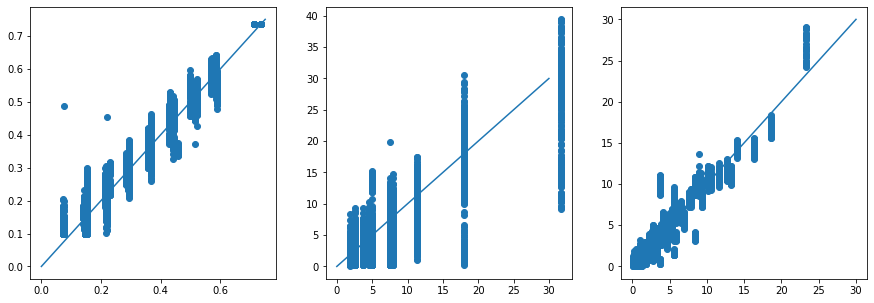

In [15]:
fig, ax = plt.subplots(nrows=1, ncols=3,figsize=(15,5))
ax[0].scatter(df['Flaw_Depth'],depth_pred)
#ax[0].scatter(df['Flaw_Depth'],depth_prediction_full)
ax[1].scatter(df['Flaw_Area'],area_pred)
#ax[1].scatter(df[df.Tube_Alias.isin(['AP02','AP01','AP05','RP05','RP06']) & df.Flaw_ID.isin(['I',])]['Flaw_Area'],
#              df[df.Tube_Alias.isin(['AP02','AP01','AP05','RP05','RP06'])&df.Flaw_ID.isin(['I'])]['area_pred'])
ax[2].scatter(df['Flaw_Volume'], volume_pred)

ax[0].plot(np.linspace(0,0.75,num=5),np.linspace(0.0,0.75,num=5))
ax[1].plot(np.linspace(0,30,num=5),np.linspace(0.0,30,num=5))
ax[2].plot(np.linspace(0,30,num=5),np.linspace(0.0,30,num=5))



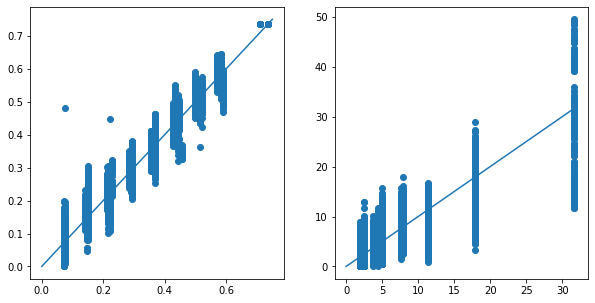

In [16]:
fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(10,5))
ax[0].scatter(df['Flaw_Depth'],depth_pred2)
ax[1].scatter(df['Flaw_Area'],area_pred2)


ax[0].plot(np.linspace(0,0.75,num=5),np.linspace(0.0,0.75,num=5))
ax[1].plot(np.linspace(0,32,num=5),np.linspace(0.0,32,num=5))

### Step 4 : Generate list of predictions on the test data

In [17]:
filename = os.path.join(os.path.dirname(os.getcwd()), 'data','interim','full_feature_test_data.csv')
test_df = pd.read_csv(filename)

In [18]:
depth_predictions, area_predictions, volume_predictions, delta_areas = predict_iterative_model(test_df, rf, ols2,
                                                        ols_v, ols_a, feature_list,
                             depth_list, volume_list, depth_a_list, tube_thickness=0.737, alpha=0.01, 
                                                     delta_threshold = 0.1, max_loops=10)

depth_pred2, area_pred2, delta_areas2 = predict_iterative_area_model(test_df, rf, ols2,
                                                        ols_area, ols_a, feature_list,
                             depth_list, area_list, depth_a_list, tube_thickness=0.737)

1 iterations


In [19]:
prediction_df=pd.DataFrame(depth_predictions, columns=['Depth'])
prediction_df['Area']=area_predictions
prediction_df['Volume']=volume_predictions

prediction_df2=pd.DataFrame(depth_pred2, columns=['Depth'])
prediction_df2['Area']=area_pred2
prediction_df2['Volume']=volume_predictions

In [20]:
prediction_df.to_csv('predictions_iter1.csv')
prediction_df2.to_csv('predictions_iter2.csv')